In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount='True')
%cd drive/My\ Drive/Colab\ Notebooks/Embeddings/clean_data/src_tgt/not_dis

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Embeddings/clean_data/src_tgt/not_dis


#Import

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import json, pathlib, os, time, datetime, gensim, sys, pickle, time, unicodedata, io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import regex as re
from tensor2tensor.utils.beam_search import beam_search

%matplotlib inline

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow 2.x selected.
Num GPUs Available:  1


#Tokenization

### Utils

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')
  
def preproc(w):
    w = unicode_to_ascii(w.strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    w = '<sos> ' + w + ' <eos>'
    return w

def create_dataset(src_path, tgt_path):
    src = io.open(src_path, encoding='UTF-8').read().strip().split('\n')
    tgt = io.open(tgt_path, encoding='UTF-8').read().strip().split('\n')
    return [preproc(line) for line in src], [preproc(line) for line in tgt]

def tokenize(cnc, snt):
    tokenizer.fit_on_texts(cnc+snt)
    cnc_tensor = tokenizer.texts_to_sequences(cnc)
    cnc_tensor = tf.keras.preprocessing.sequence.pad_sequences(cnc_tensor, padding='post', dtype='int64')
    snt_tensor = tokenizer.texts_to_sequences(snt)
    snt_tensor = tf.keras.preprocessing.sequence.pad_sequences(snt_tensor, padding='post', dtype='int64')
    return cnc_tensor, snt_tensor, tokenizer

def load_dataset(src_path, tgt_path):
    cnc, snt = create_dataset(src_path, tgt_path)
    input_tensor, target_tensor, inp_lang_tokenizer = tokenize(cnc, snt)
    return input_tensor, target_tensor, tokenizer

def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

def max_length(tensor):
  return max(len(t) for t in tensor)

### Dataset creation

In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
cnc_tensor, snt_tensor, tokenizer = load_dataset('concepts.txt', 'sentences.txt')
cnc_tensor_train, cnc_tensor_val, snt_tensor_train, snt_tensor_val = train_test_split(cnc_tensor, snt_tensor, test_size=0.1)

BUFFER_SIZE = len(cnc_tensor_train)
BATCH_SIZE = 32

vocab_size = len(tokenizer.word_index)+1
max_length_targ, max_length_inp = max_length(snt_tensor), max_length(cnc_tensor)

dataset = tf.data.Dataset.from_tensor_slices((cnc_tensor_train, snt_tensor_train)).shuffle(BUFFER_SIZE)
train_dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

for ex in train_dataset.take(1):
    inp = ex[0][0]
    tar = ex[1][0]
    print('concepts: {}\nsentence: {}'.format(
            ' '.join([tokenizer.index_word[i.numpy()] for i in inp if i!=0]), 
            ' '.join([tokenizer.index_word[i.numpy()] for i in tar if i!=0])
        ))

concepts: <sos> participate force helicopter <eos>
sentence: <sos> the armed forces participated with their brand new helicopter . <eos>


#Weights and Biases

In [5]:
# !pip install wandb -q
import wandb
wandb.login()

wandb.init(entity = "edivairanatnom", project = "transformer-not-dis", sync_tensorboard=True)

config = wandb.config
config.batch_size = 32         
config.num_steps = 50000
config.display_step = 10
config.num_layers = 6
config.d_model = 2048
config.dff = 1024
config.num_heads = 8
config.vocab_size = vocab_size
config.dropout_rate = 0.1

#Transformer

##Pos Encoding

In [0]:
### POSITION

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

##Masks

In [0]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

##Attention

In [0]:
def scaled_dot_product_attention(q, k, v, mask):

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
            
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights

##Feedforward

In [0]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

##Encoder

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        
        return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

##Decoder

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)
    
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):   # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
    
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
      
        return x, attention_weights

##Seq2Seq

In [0]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

#Hyperparameters

In [0]:
num_layers = 6
d_model = 2048
dff = 1024
num_heads = 8
input_vocab_size = target_vocab_size = len(tokenizer.word_index)+1
dropout_rate = 0.1

#LR Scheduler, Optimizer and Loss

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

transformer = Transformer(num_layers, d_model, 
                          num_heads, dff, 
                          input_vocab_size, 
                          target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size, 
                          rate=dropout_rate)

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

#Checkpoint

In [0]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

#Generation

In [0]:
def evaluate(inp_sentence):
    inp_sentence = [tokenizer.word_index[t] for t in inp_sentence.split(' ') if t!=0]
    encoder_input = tf.expand_dims(inp_sentence, 0)

    decoder_input = [tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
        
    for i in range(max_length_targ):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        predictions, attention_weights = transformer(encoder_input, 
                                                    output,
                                                    False,
                                                    enc_padding_mask,
                                                    combined_mask,
                                                    dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights
        
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
    sentence = [tokenizer.word_index[t] for t in sentence.split(' ') if t!=0]
    attention = tf.squeeze(attention[layer], axis=0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        fontdict = {'fontsize': 10}
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
        ax.set_ylim(len(result)-1.5, -0.5)
        ax.set_xticklabels(
            [tokenizer.index_word[i] for i in sentence if i!=0], 
            fontdict=fontdict, rotation=90)
        ax.set_yticklabels([tokenizer.index_word[i.numpy()] for i in result if i < target_vocab_size and i!=0], 
                        fontdict=fontdict)
        ax.set_xlabel('Head {}'.format(head+1))
    
    plt.tight_layout()
    plt.show()

def generate(concepts, plot=''):
    result, attention_weights = evaluate(concepts)
    predicted_sentence = [tokenizer.index_word[t.numpy()] for t in result if t < target_vocab_size and t!=0]
    print('Input: {}'.format(concepts))
    print('Predicted sentence: {}'.format(predicted_sentence))
    
    if plot:
        plot_attention_weights(attention_weights, concepts, result, plot)

#Train

##Step

In [0]:
EPOCHS = 40

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                    True, 
                                    enc_padding_mask, 
                                    combined_mask, 
                                    dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)

##Loop

---------------------------------------
Epoch 1 Loss 4.90 Accuracy 0.0
---------------------------------------

Input: <sos> arrival festival screening <eos>
Predicted sentence: ['<sos>', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads', 'loads']


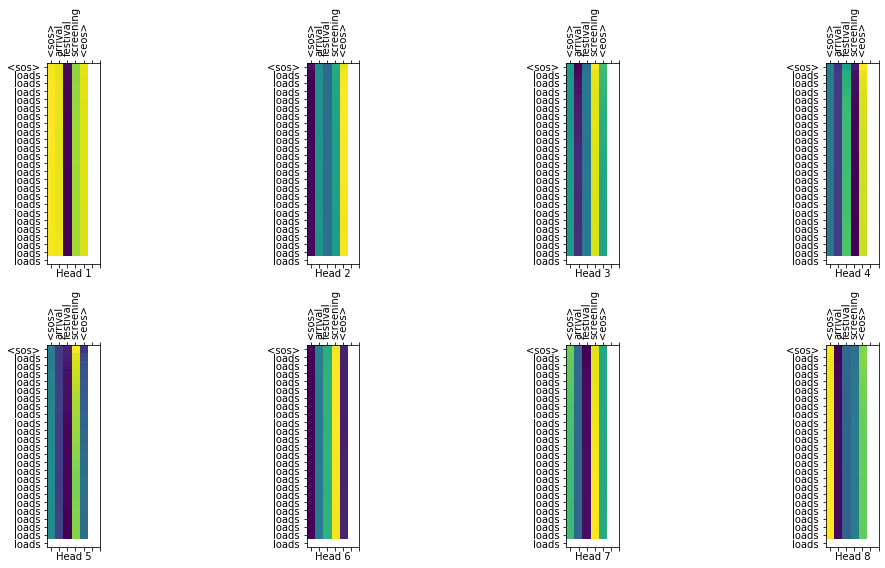

Gold sentence: <sos> actor poses upon arrival for the screening of the film at festival <eos>

---------------------------------------
Epoch 2 Loss 3.13 Accuracy 7.4
---------------------------------------

Input: <sos> supermarket brand sale <eos>
Predicted sentence: ['<sos>', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'the', 'of']


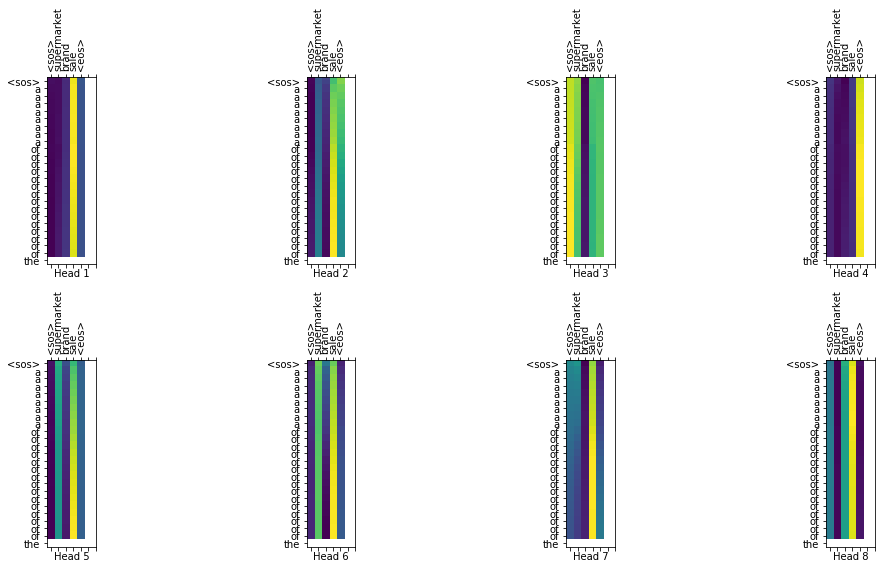

Gold sentence: <sos> fresh fish on ice in a box made of brand at supermarket for sale <eos>

---------------------------------------
Epoch 3 Loss 2.40 Accuracy 13.4
---------------------------------------

Input: <sos> reflect surface sunlight <eos>
Predicted sentence: ['<sos>', 'sunlight', 'sunlight', 'of', 'the', 'sunlight', 'of', 'the', 'sunlight']


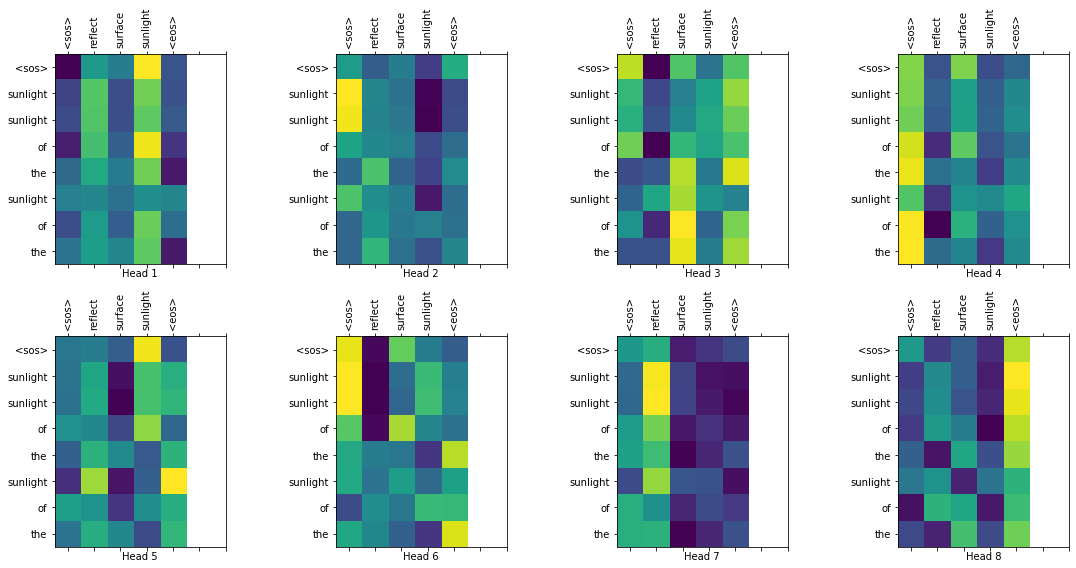

Gold sentence: <sos> sunlight and clouds reflect off the surface of a pond . <eos>

---------------------------------------
Epoch 4 Loss 2.16 Accuracy 13.3
---------------------------------------

Input: <sos> butterfly exhibition garden <eos>
Predicted sentence: ['<sos>', 'a', 'person', 'of', 'a', 'garden', 'of', 'a', 'garden', 'of', 'the', 'garden']


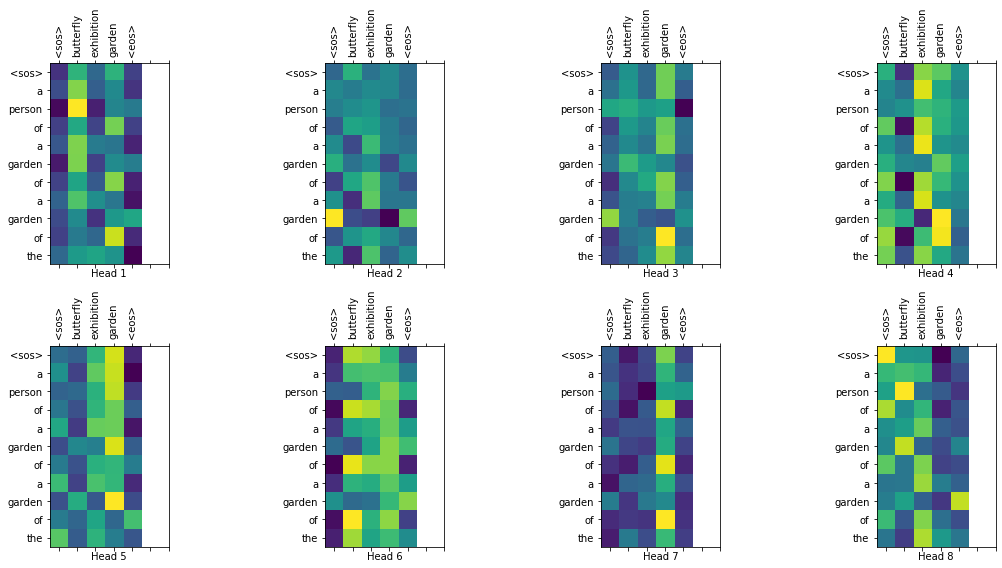

Gold sentence: <sos> a butterfly sits on a leaf during an exhibition of tropical butterflies at the botanical garden <eos>

---------------------------------------
Epoch 5 Loss 1.80 Accuracy 18.4
---------------------------------------

Input: <sos> approach landing airport <eos>
Predicted sentence: ['<sos>', 'approaching', 'the', 'approaching', 'landing']


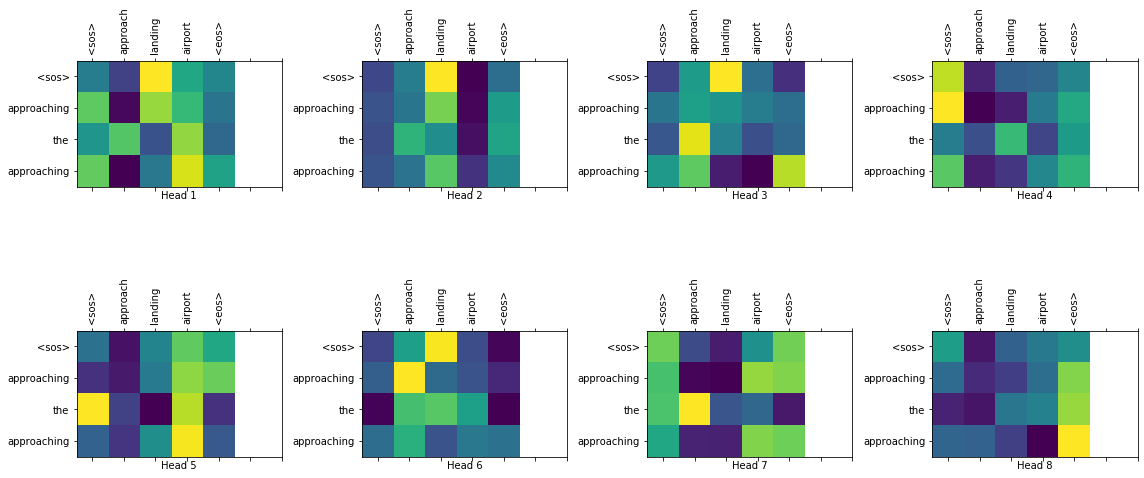

Gold sentence: <sos> person approaching airport for a landing <eos>

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
---------------------------------------
Epoch 6 Loss 1.87 Accuracy 15.9
---------------------------------------

Input: <sos> attend residence actor <eos>
Predicted sentence: ['<sos>', 'actor', 'attends', 'the', 'private', 'party', 'hosted', 'by', 'actor', '.']


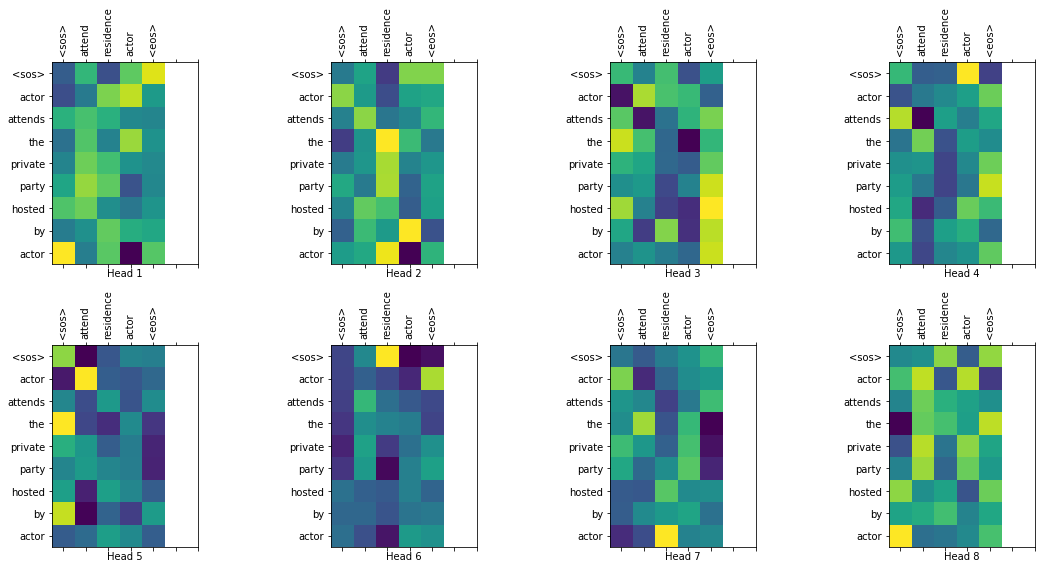

Gold sentence: <sos> actor and ceo of person attend event held at a private residence . <eos>

---------------------------------------
Epoch 7 Loss 1.55 Accuracy 19.8
---------------------------------------

Input: <sos> september festival premiere <eos>
Predicted sentence: ['<sos>', 'actor', 'and', 'person', 'at', 'the', 'premiere', 'at', 'festival', '.']


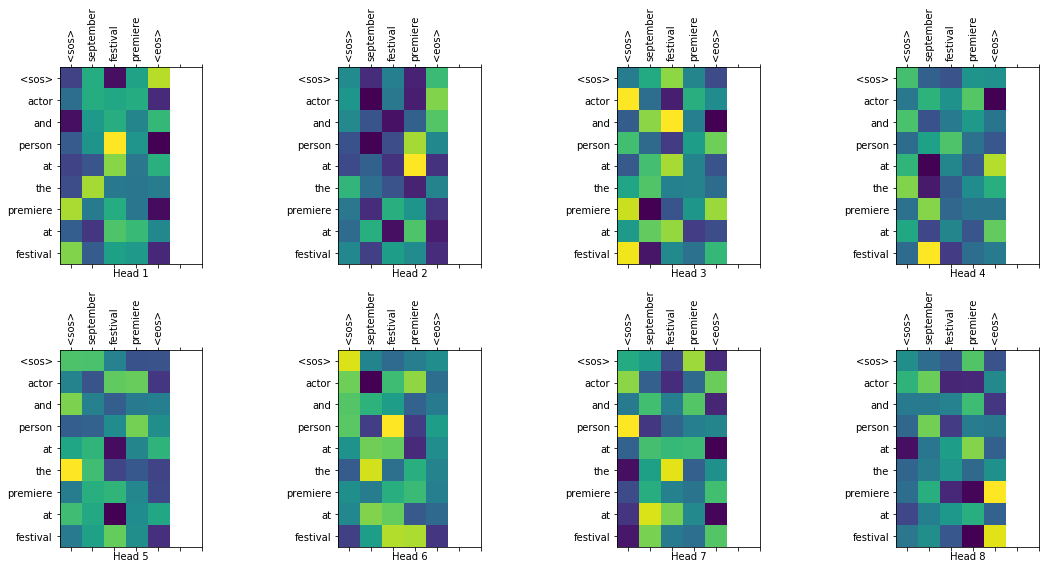

Gold sentence: <sos> person hit the red carpet in a gown for premiere at festival in september . <eos>

---------------------------------------
Epoch 8 Loss 1.83 Accuracy 17.4
---------------------------------------

Input: <sos> meadow grazing spring <eos>
Predicted sentence: ['<sos>', 'a', 'male', 'grazing', 'in', 'a', 'field', 'in', 'a', 'field', 'in', 'a', 'field', 'in', 'a', 'field', 'in', 'a', 'spring']


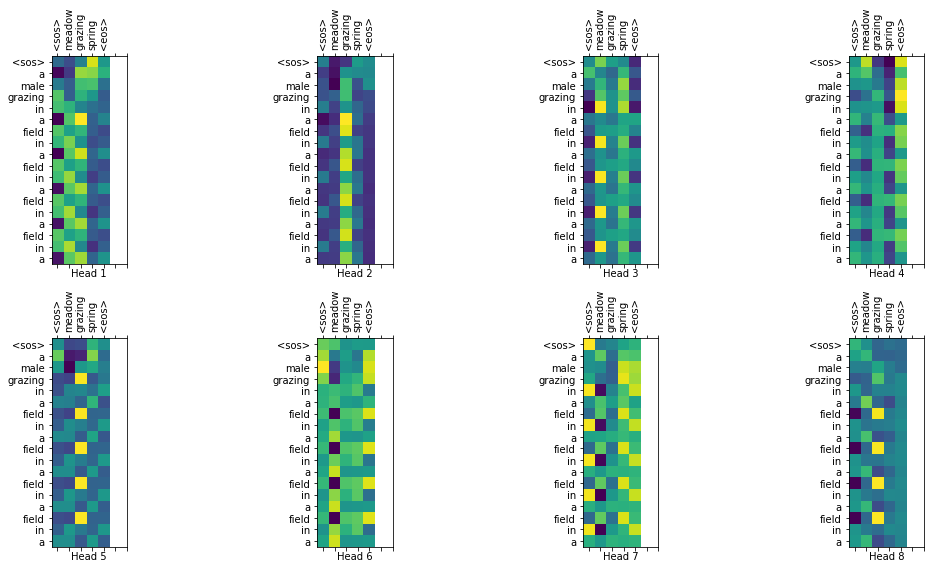

Gold sentence: <sos> a horse grazing in the alpine meadows in early spring . <eos>

---------------------------------------
Epoch 9 Loss 1.97 Accuracy 14.6
---------------------------------------

Input: <sos> classmate exam copy classroom <eos>
Predicted sentence: ['<sos>', 'student', 'trying', 'in', 'classroom', 'exam', 'exam', 'exam', 'exam', 'exam', 'exam', 'exam', 'exam', 'exam', 'in', 'classroom']


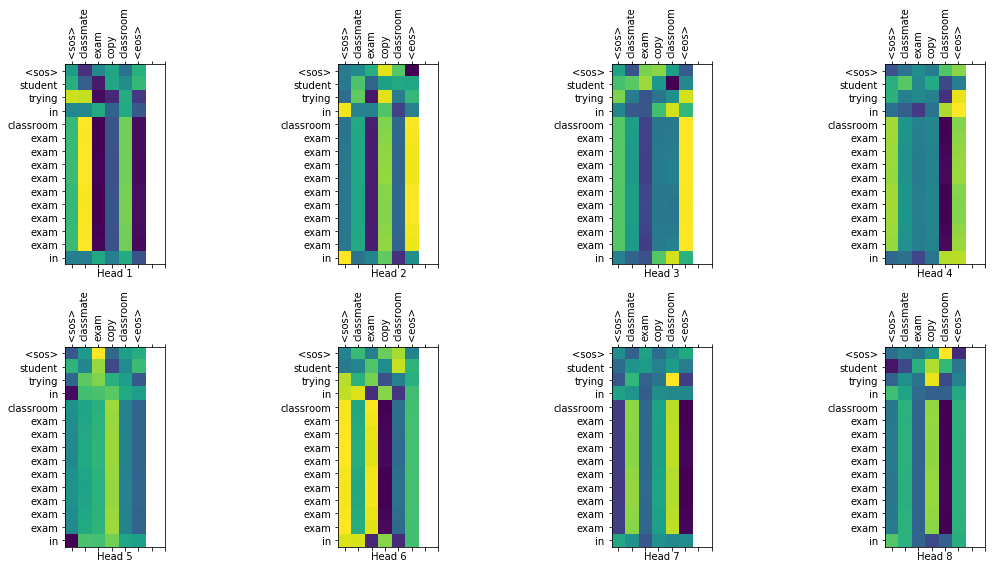

Gold sentence: <sos> student trying to copy an exam from another classmate at classroom <eos>

---------------------------------------
Epoch 10 Loss 2.81 Accuracy 8.6
---------------------------------------

Input: <sos> year language wish nation <eos>
Predicted sentence: ['<sos>', 'anyone', 'is', 'anyone', 'wants', 'for', 'the', 'year']


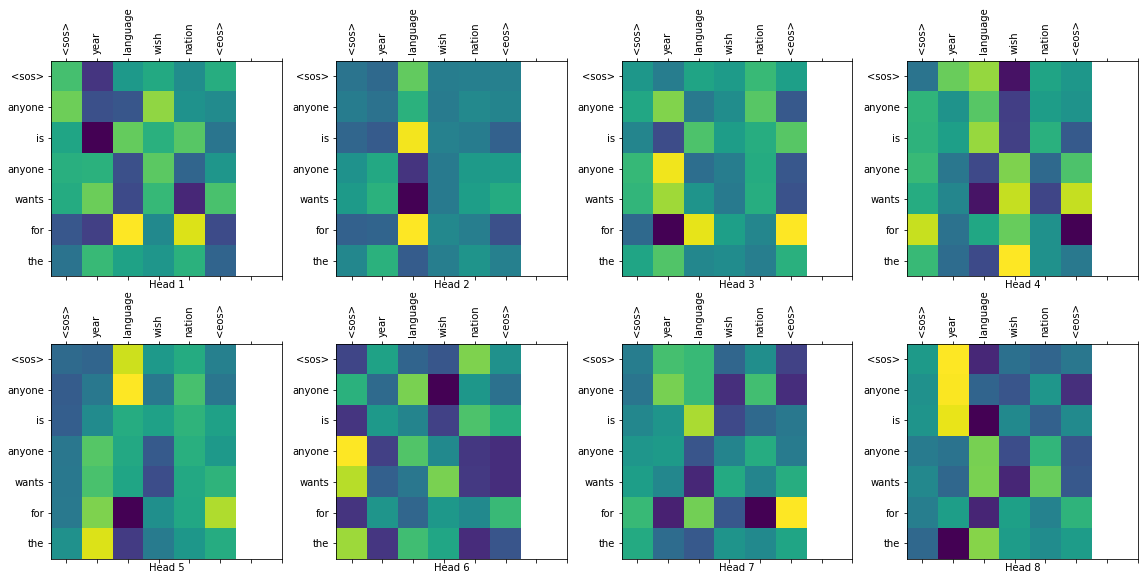

Gold sentence: <sos> christmas greeting and new year wishes in the nations own language at a live moving card <eos>

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
---------------------------------------
Epoch 11 Loss 3.10 Accuracy 3.8
---------------------------------------

Input: <sos> demonstrator rally part <eos>
Predicted sentence: ['<sos>', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


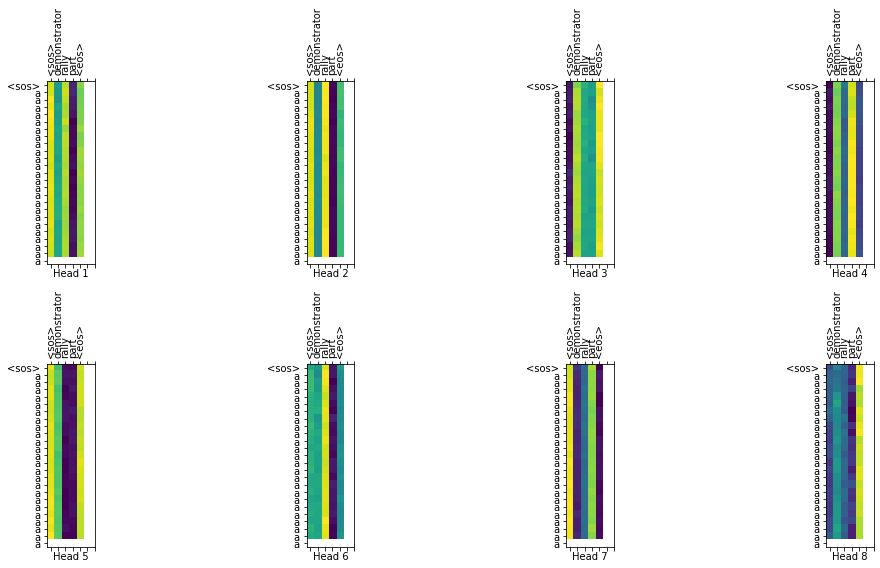

Gold sentence: <sos> demonstrators take part in a rally outside of headquarters . <eos>

---------------------------------------
Epoch 12 Loss 2.89 Accuracy 3.8
---------------------------------------

Input: <sos> tower recognize landmark <eos>
Predicted sentence: ['<sos>', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


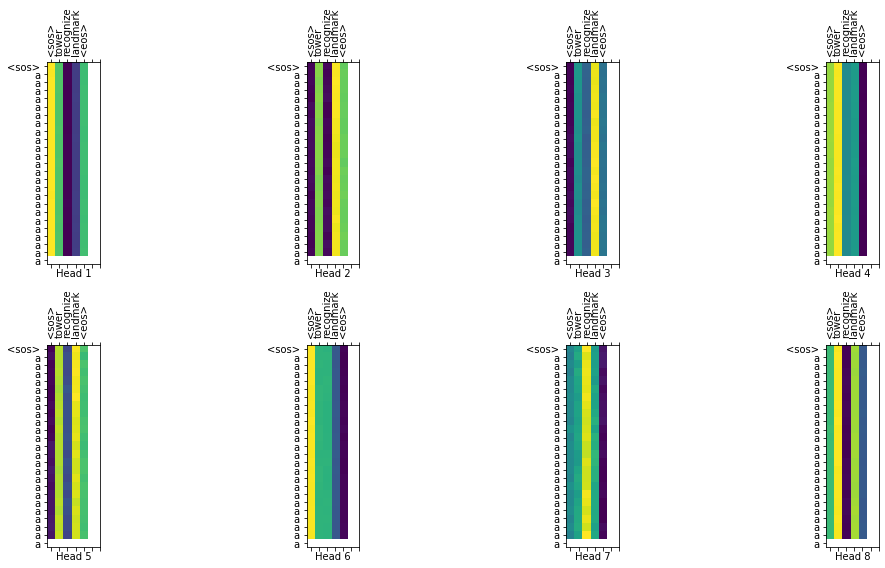

Gold sentence: <sos> the bell tower is definitely one of the most recognized landmarks <eos>

---------------------------------------
Epoch 13 Loss 2.76 Accuracy 5.1
---------------------------------------

Input: <sos> spot actor sport <eos>
Predicted sentence: ['<sos>', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor']


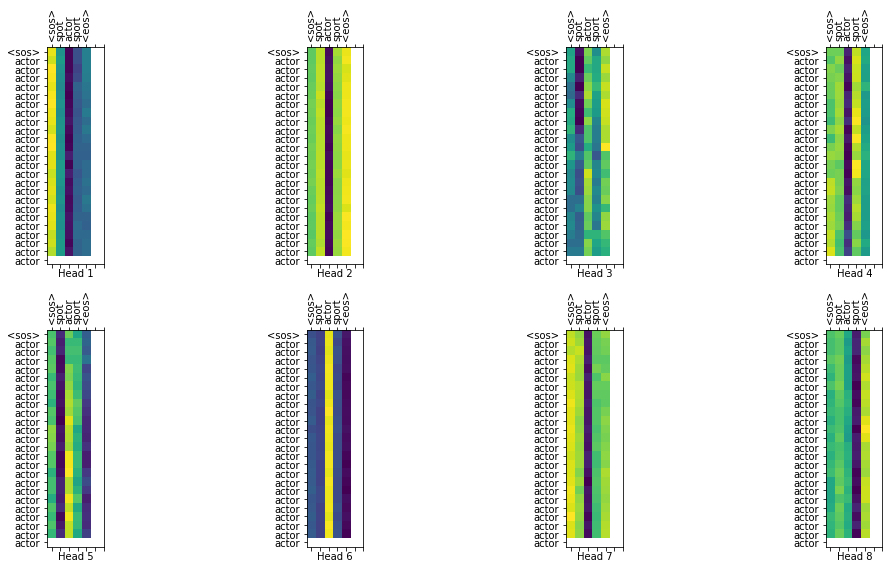

Gold sentence: <sos> actor was spotted sporting the cap gifted to him by the army . <eos>

---------------------------------------
Epoch 14 Loss 2.62 Accuracy 6.4
---------------------------------------

Input: <sos> sole cobbler shoe workshop <eos>
Predicted sentence: ['<sos>', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


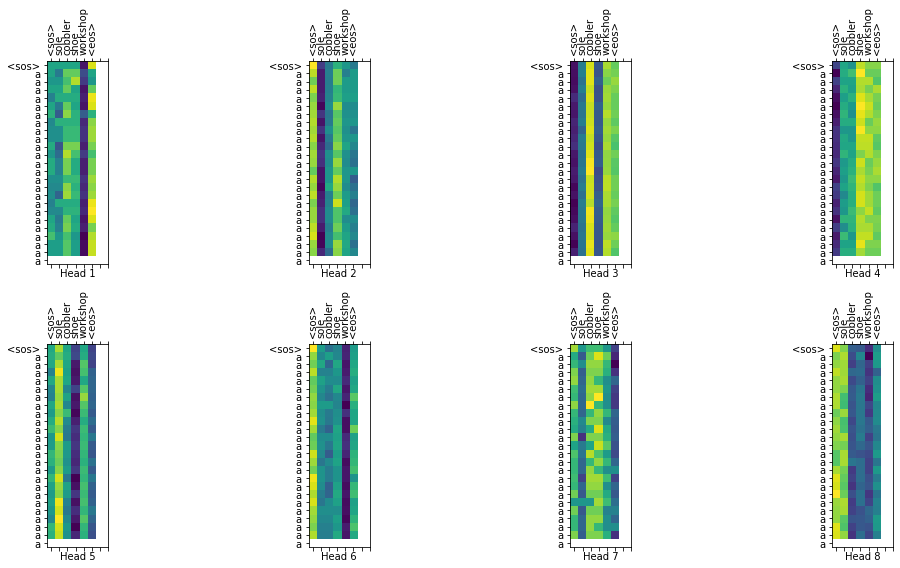

Gold sentence: <sos> profile view of cobbler cutting the sole of a shoe in his workshop <eos>

---------------------------------------
Epoch 15 Loss 2.50 Accuracy 5.2
---------------------------------------

Input: <sos> actor model stroll <eos>
Predicted sentence: ['<sos>', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model']


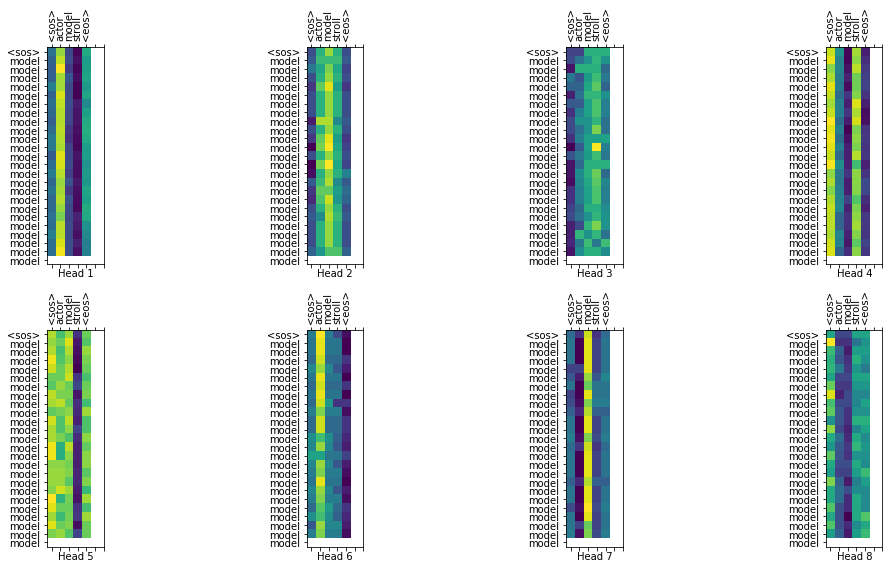

Gold sentence: <sos> actor and model take a stroll with their baby daughter <eos>



KeyboardInterrupt: ignored

In [18]:
train_loss_vals = []
train_acc_vals = []

for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch == 0:
            print('---------------------------------------')
            print ('Epoch {} Loss {:.2f} Accuracy {:.1f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()*100))
            print('---------------------------------------\n')
            train_loss_vals.append(train_loss.result().numpy())
            train_acc_vals.append(train_accuracy.result().numpy()*100)
            generate(' '.join([tokenizer.index_word[i.numpy()] for i in inp[0] if i!=0]), plot='decoder_layer6_block2')
            print ("Gold sentence: {}\n".format(' '.join([tokenizer.index_word[i.numpy()] for i in tar[0] if i!=0])))
        
        wandb.log({'Train Accuracy': train_accuracy.result()*100, 'Train Loss': train_loss.result()})

    epochs = range(1, len(train_loss_vals) + 1)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))